# Graph Analysis

## Setting up

In [1]:
import ipywidgets as widgets
import pandas as pd 
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colorsys
import itertools
import networkx as nx
import igraph as ig
import gc
import pickle

In [2]:
PATH = "edge_lists/"
HISTORY = 5
SUFFIX = "convolution_" if HISTORY in [4,8] else "positive_exact_"
GRAPH_SUFFIX = "Convolution" if HISTORY in [4,8] else "History"
WEIGHTS = True
WEIGHT_SUFFIX = "weighted_" if WEIGHTS else ""
GRAPH_WEIGHT_SUFFIX = "Weighted" if WEIGHTS else ""

## Compare different approaches

In [3]:
def compare_all_to_positive_edges(f1_path,f2_path):
    df1 = pd.read_csv(f1_path,header=None, sep=' ',dtype='int32')
    df1.rename(columns={0: 'from', 1: 'to', 2: 'weight'}, inplace=True)
    df1 = df1[df1['weight'] > 0]

    df2 = pd.read_csv(f2_path,header=None, sep=' ',dtype='int32')
    df2.rename(columns={0: 'from', 1: 'to', 2: 'weight'}, inplace=True)

    merged_df = pd.merge(df1, df2, on=['from', 'to'], how='outer', suffixes=('_file1', '_file2'))
    merged_df['result_weight'] = merged_df['weight_file2'].sub(merged_df['weight_file1'], fill_value=0)

    del df1
    del df2
    gc.collect()
    
    return merged_df


In [4]:
def print_postive_edges_statistics(merged_df,history,f1_title,f2_title):
    print(f"Comparing files: {f1_title} vs. {f2_title} (History length: {history})")
    print(f"Average weight difference per edge: {round(merged_df['result_weight'].mean(),4)}")
    print(f"Average weight difference per edge from edges with difference: {round(merged_df['result_weight'][merged_df['result_weight'] != 0].mean(),4)}")
    nan_count_f1 = len(merged_df[merged_df['weight_file1'].isna()])
    nan_count_f2 = len(merged_df[merged_df['weight_file2'].isna()])
    print(f"Count of edges in '{f2_title}' that are not in '{f1_title}': {nan_count_f1}")
    print(f"Count of edges in '{f1_title}' that are not in '{f2_title}': {nan_count_f2}")
    print(f"Count of edges in that are in union: {len(merged_df)}")
    print(f"Percentage of edges in '{f2_title}' that are not in union: {round(nan_count_f1*100/len(merged_df),4)}%")
    print(f"Percentage of edges in '{f1_title}' that are not in union: {round(nan_count_f2*100/len(merged_df),4)}%")
    print(f"Percentage of edges in both graphs and are  are not in union: {round((len(merged_df)-nan_count_f1-nan_count_f2)*100/len(merged_df),4)}%")

In [21]:
merged_df_3 = compare_all_to_positive_edges(PATH+'2022_graph_weighted_edges_positive_exact_3.txt',PATH+'2022_graph_weighted_edges_positive_3.txt')
print_postive_edges_statistics(merged_df_3,3,'positive edges','positive exac')

Comparing files: positive edges vs. positive exac (History length: 3)
Average weight difference per edge: 0.0225
Average weight difference per edge from edges with difference: 1.2069
Count of edges in 'positive exac' that are not in 'positive edges': 2168981
Count of edges in 'positive edges' that are not in 'positive exac': 0
Count of edges in that are in union: 150324900
Percentage of edges in 'positive exac' that are not in union: 1.4429%
Percentage of edges in 'positive edges' that are not in union: 0.0%
Percentage of edges in both graphs and are  are not in union: 98.5571%


In [22]:
del merged_df_3
gc.collect()

0

In [5]:
merged_df_5 = compare_all_to_positive_edges(PATH+'2022_graph_weighted_edges_positive_exact_5.txt',PATH+'2022_graph_weighted_edges_positive_5.txt')
print_postive_edges_statistics(merged_df_5,5,'positive edges','positive exac')

Comparing files: positive edges vs. positive exac (History length: 5)
Average weight difference per edge: 0.0262
Average weight difference per edge from edges with difference: 1.2399
Count of edges in 'positive exac' that are not in 'positive edges': 4049196
Count of edges in 'positive edges' that are not in 'positive exac': 0
Count of edges in that are in union: 251315192
Percentage of edges in 'positive exac' that are not in union: 1.6112%
Percentage of edges in 'positive edges' that are not in union: 0.0%
Percentage of edges in both graphs and are  are not in union: 98.3888%


In [ ]:
del merged_df_5
gc.collect()

In [5]:
merged_df_4 = compare_all_to_positive_edges(PATH+'2022_graph_weighted_edges_positive_exact_5.txt',PATH+'2022_graph_weighted_edges_convolution_4.txt')
print_postive_edges_statistics(merged_df_4,4,'convolution','positive exac')

Comparing files: convolution vs. positive exac (History length: 4)
Average weight difference per edge: 0.0545
Average weight difference per edge from edges with difference: 0.0553
Count of edges in 'positive exac' that are not in 'convolution': 256323988
Count of edges in 'convolution' that are not in 'positive exac': 235738949
Count of edges in that are in union: 503589984
Percentage of edges in 'positive exac' that are not in union: 50.8993%
Percentage of edges in 'convolution' that are not in union: 46.8117%
Percentage of edges in both graphs and are  are not in union: 2.289%


In [ ]:
del merged_df_4
gc.collect()

In [ ]:
# too much memory intensive
#merged_df_8 = compare_all_to_positive_edges(PATH+'2022_graph_weighted_edges_positive_exact_.10txt',PATH+'2022_graph_weighted_edges_convolution_8.txt')
#print_postive_edges_statistics(merged_df_8,8,'convolution','positive exac')


In [ ]:
del merged_df_8
gc.collect()

## Load Graph

In [7]:
edge_list_path = PATH+'2022_graph_weighted_edges_' + SUFFIX + str(HISTORY)+'.txt'

In [4]:
N = 0
with open('users.npy', 'rb') as f:
    N = len(np.load(f, allow_pickle=True))
N


10257345

In [5]:
def load_weighted_edgelist(file_path, skiprows = None,nrows = None):
    print("Starting: Loading edge list")
    df = pd.read_csv(file_path,header=None, sep=' ',dtype='int32',skiprows= skiprows, nrows = nrows)
    df.rename(columns={0: 'X', 1: 'Y', 2: 'W'}, inplace=True)
    edges =  np.column_stack((df['X'].values, df['Y'].values))
    weights = np.array(df['W'].values)
    del df
    gc.collect()
    print("Ending: Edge list loaded")
    return (edges,weights)

def create_weighted_graph(N, edges, weights):
    print("Starting: Creating graph")
    g = ig.Graph(
        n=N, edges=edges,
        edge_attrs= {'weight': weights}
    )
    print("Ending: Graph created")
    return g

In [10]:
# a bit RAM inefficient but fast
def load_graph_from_weighted_edgelist(file_path,N):
    edges,weights = load_weighted_edgelist(file_path)
    g = create_weighted_graph(N, edges, weights)
    del weights
    del edges
    gc.collect()
    return g

#slower but ok
def load_graph_from_weighted_edgelist_batches(file_path,N,batch=10000000):
    g = ig.Graph(n=N, directed=False)
    
    rowcount  = 0
    for row in open(file_path): 
        rowcount+= 1
        
    print("Edge count ",rowcount)
    batch_N = (rowcount//batch)+1
    print("Batches ",batch_N)
    for i in range(batch_N):
        print(f"Batch num {i+1}/{batch_N}")
        edges,weights = load_weighted_edgelist(file_path,i*batch,batch)
        g.add_edges(edges, attributes={'weight': weights})
        del weights
        del edges
        gc.collect()
    return g

#too slow
def load_graph_from_weighted_edgelist_directly(file_path,N):
    g = ig.Graph(n=N, directed=False)
    with open(file_path, 'r') as file:
        for line in file:
            from_vertex, to_vertex, weight = map(int, line.strip().split())
            g.add_edge(from_vertex, to_vertex, weight=weight)
    return g


In [21]:
g = load_graph_from_weighted_edgelist(edge_list_path,N)

Starting: Loading edge list
Ending: Edge list loaded
Starting: Creating graph
Ending: Graph created


In [7]:
g = load_graph_from_weighted_edgelist_batches(edge_list_path,N,100000000)

Edge count  267851035
Batches  3
Batch num 1/3
Starting: Loading edge list
Ending: Edge list loaded
Batch num 2/3
Starting: Loading edge list
Ending: Edge list loaded
Batch num 3/3
Starting: Loading edge list
Ending: Edge list loaded


In [ ]:
# g = load_graph_from_weighted_edgelist_directly(edge_list_path,N)

In [22]:
vertices_degree = [v.degree() for v in g.vs]
v_non_i = np.count_nonzero(vertices_degree)
v_i = len(vertices_degree) - v_non_i
v_count = g.vcount()
e_count = g.ecount()
density = g.density()
weights = g.es["weight"]

In [23]:
print(f"History: {HISTORY}")
print(f"Number of vertices: {v_count}")
print(f"Isolated vertices count: {v_i} (percentige {100*v_i/v_count:.3f}%)")
print(f"Non-Isolated vertices count: {v_non_i} (percentige {100*v_non_i/v_count:.3f}%)")
print(f"Number of edges: {e_count}")
print(f"Edge density: {density:.3e}")

History: 3
Number of vertices: 10257345
Isolated vertices count: 1025945 (percentige 10.002%)
Non-Isolated vertices count: 9231400 (percentige 89.998%)
Number of edges: 148155919
Edge density: 2.816e-06


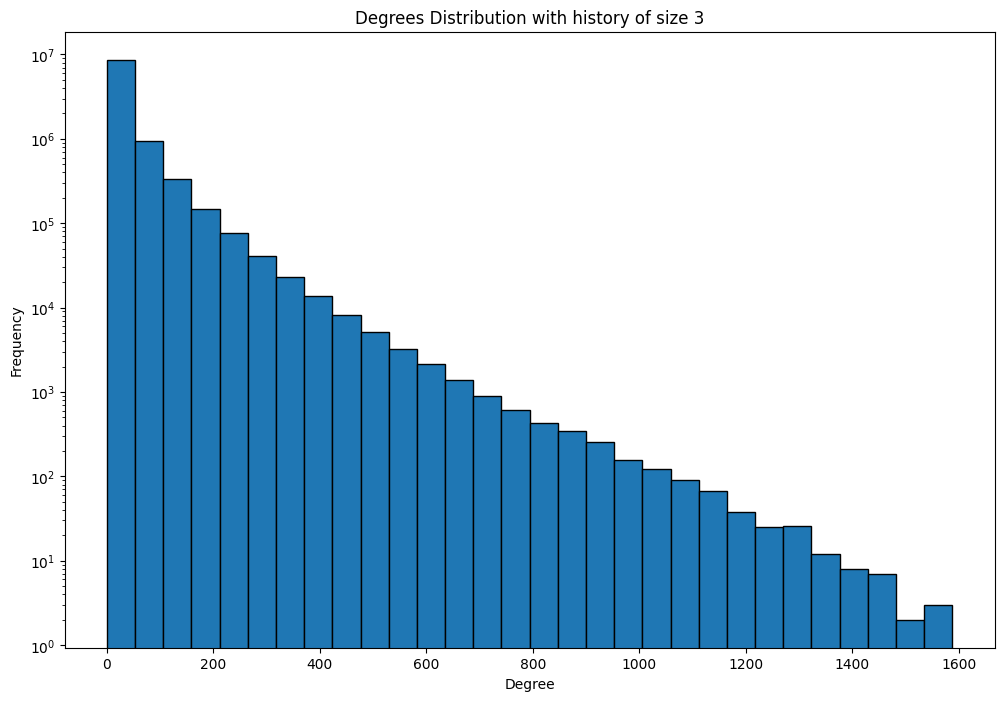

In [25]:
plt.figure(figsize=(12,8))

plt.hist(vertices_degree,bins= 30, edgecolor='black')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Degree')
plt.ylabel('Frequency (log scale)')
plt.title(f'Degrees Distribution in Graph created with {GRAPH_SUFFIX} of size {HISTORY}')

plt.savefig(f"Degrees_{GRAPH_SUFFIX}_{HISTORY}.png")

In [1]:
plt.figure(figsize=(12,8))

plt.hist(weights,bins= 30, edgecolor='black')

plt.yscale('log')

plt.xlabel('Weight')
plt.ylabel('Frequency (log scale)')
plt.title(f'Weight Distribution in Graph created with {GRAPH_SUFFIX} of size {HISTORY}')

plt.savefig(f"Weights_{GRAPH_SUFFIX}_{HISTORY}.png")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
for i in [3,4,5,8,10]:
    HISTORY = i
    SUFFIX = ("convolution_" if HISTORY in [4,8] else "positive_exact_")
    GRAPH_SUFFIX = "convolution" if HISTORY in [4,8] else "history"

    edge_list_path = PATH+'2022_graph_weighted_edges_' + SUFFIX + str(HISTORY)+'.txt'
    edges,weights = load_weighted_edgelist(edge_list_path)
    vertices, vertices_degree = np.unique(edges, return_counts=True)
    # v_non_i = len(vertices)
    # v_count = N
    # v_i = N-v_non_i
    # e_count = len(edges)
    # density = 2*len(edges)/(N*N-1)

    # print(f"History: {HISTORY}")
    # print(f"Number of vertices: {v_count}")
    # print(f"Isolated vertices count: {v_i} (percentige {100*v_i/v_count:.3f}%)")
    # print(f"Non-Isolated vertices count: {v_non_i} (percentige {100*v_non_i/v_count:.3f}%)")
    # print(f"Number of edges: {e_count}")
    # print(f"Edge density: {density:.3e}")

    plt.figure(figsize=(12,8))

    plt.hist(vertices_degree,bins= 30, edgecolor='black')

    # plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('Degree')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Degrees Distribution in Graph created with {GRAPH_SUFFIX} of size {HISTORY}')

    plt.savefig(f"Degrees_{GRAPH_SUFFIX}_{HISTORY}.png")
    plt.show()
    plt.clf()

    plt.figure(figsize=(12,8))

    plt.hist(weights,bins= 30, edgecolor='black')

    plt.yscale('log')

    plt.xlabel('Weight')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Weight Distribution in Graph created with {GRAPH_SUFFIX} of size {HISTORY}')

    plt.savefig(f"Weights_{GRAPH_SUFFIX}_{HISTORY}.png")
    plt.show()
    plt.clf()

#     # del weights
#     # del edges
#     # gc.collect()

Starting: Loading edge list
Ending: Edge list loaded
Starting: Loading edge list
Ending: Edge list loaded
Starting: Loading edge list
Ending: Edge list loaded


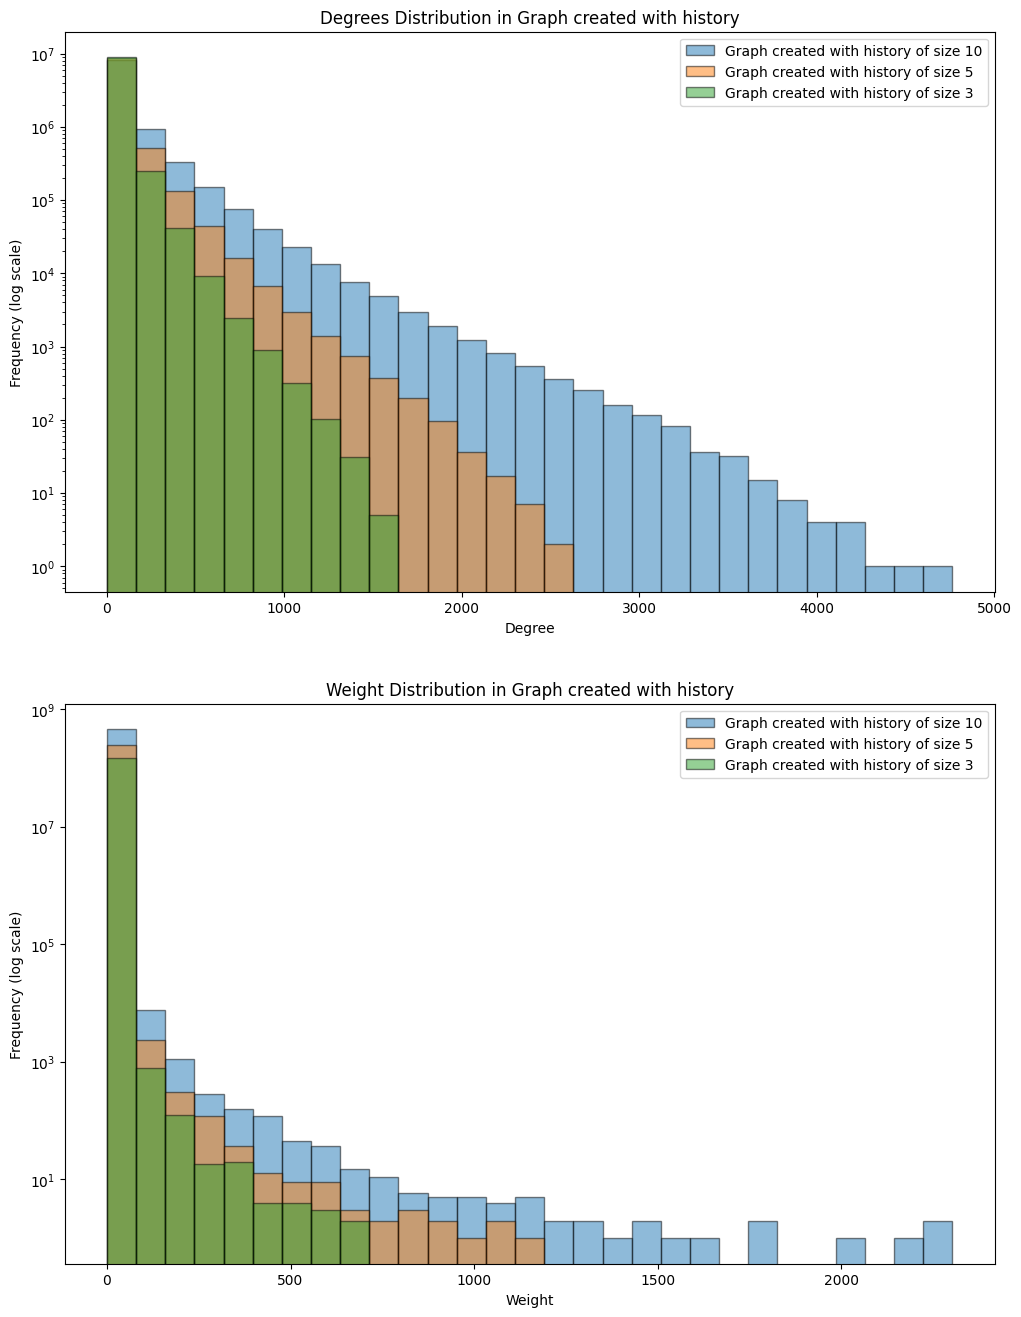

In [28]:
# graphs_to_plot = [8,4]
# graphs_to_plot = [10,5,3]
fig, ax = plt.subplots(2,1,figsize=(12,16))

for i in graphs_to_plot:
    HISTORY = i
    SUFFIX = "convolution_" if HISTORY in [4,8] else "positive_exact_"
    GRAPH_SUFFIX = "convolution" if HISTORY in [4,8] else "history"

    edge_list_path = PATH+'2022_graph_weighted_edges_' + SUFFIX + str(HISTORY)+'.txt'
    edges,weights = load_weighted_edgelist(edge_list_path)
    vertices, vertices_degree = np.unique(edges, return_counts=True)
    degree_n_bins,weights_n_bins
    if i == graphs_to_plot[0]:
        degree_n_bins = np.linspace(0, np.max(vertices_degree) , 30)
        weights_n_bins = np.linspace(0, np.max(weights) , 30)

    ax[0].hist(vertices_degree,bins= degree_n_bins, edgecolor='black',alpha = 0.5,label =f"Graph created with {GRAPH_SUFFIX} of size {HISTORY}")
    ax[1].hist(weights,bins= weights_n_bins, edgecolor='black',alpha = 0.5, label =f"Graph created with {GRAPH_SUFFIX} of size {HISTORY}")


ax[0].set_yscale('log')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency (log scale)')
ax[0].set_title(f'Degrees Distribution in Graph created with {GRAPH_SUFFIX}')
ax[0].legend()

extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(f"Degrees_{GRAPH_SUFFIX}.png", bbox_inches=extent.expanded(1.2,1.2))

ax[1].set_yscale('log')
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('Frequency (log scale)')
ax[1].set_title(f'Weight Distribution in Graph created with {GRAPH_SUFFIX}')
ax[1].legend()

extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(f"Weights_{GRAPH_SUFFIX}.png", bbox_inches=extent.expanded(1.2,1.2))

plt.show()



Starting: Loading edge list
Ending: Edge list loaded
Starting: Loading edge list
Ending: Edge list loaded


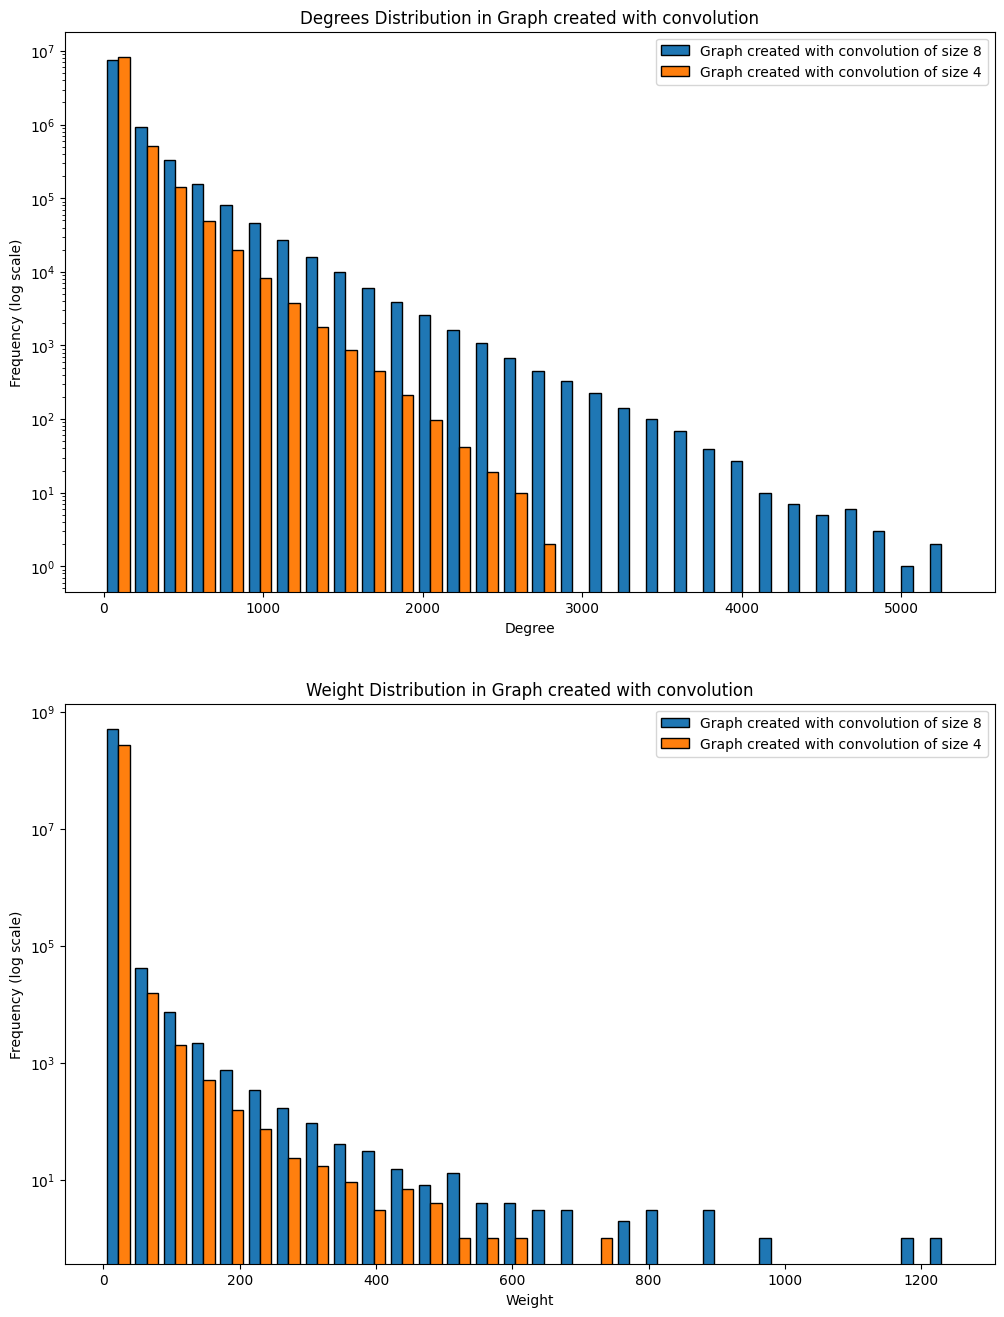

In [29]:
# graphs_to_plot = [8,4]
# graphs_to_plot = [10,5,3]
fig, ax = plt.subplots(2,1,figsize=(12,16))

vertices_degree_list =[]
weights_list=[]
labels =[]

for i in graphs_to_plot:
    HISTORY = i
    SUFFIX = "convolution_" if HISTORY in [4,8] else "positive_exact_"
    GRAPH_SUFFIX = "convolution" if HISTORY in [4,8] else "history"

    edge_list_path = PATH+'2022_graph_weighted_edges_' + SUFFIX + str(HISTORY)+'.txt'
    edges,weights = load_weighted_edgelist(edge_list_path)
    vertices, vertices_degree = np.unique(edges, return_counts=True)
    vertices_degree_list.append(vertices_degree)
    weights_list.append(weights)
    labels.append(f"Graph created with {GRAPH_SUFFIX} of size {HISTORY}")

ax[0].hist(vertices_degree_list,bins=30,edgecolor='black',label =labels)
ax[1].hist(weights_list,bins=30,edgecolor='black', label =labels)

ax[0].set_yscale('log')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Frequency (log scale)')
ax[0].set_title(f'Degrees Distribution in Graph created with {GRAPH_SUFFIX}')
ax[0].legend()

extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(f"Degrees_{GRAPH_SUFFIX}_.png", bbox_inches=extent.expanded(1.2,1.2))

ax[1].set_yscale('log')
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('Frequency (log scale)')
ax[1].set_title(f'Weight Distribution in Graph created with {GRAPH_SUFFIX}')
ax[1].legend()

extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(f"Weights_{GRAPH_SUFFIX}_.png", bbox_inches=extent.expanded(1.2,1.2))

plt.show()

## Clustering

In [26]:
# clustering
# 3 = 25min
# 5 = 25min
print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

07-01-2024 15:48:25


In [27]:
clusters = g.community_multilevel(weights= g.es["weight"] if WEIGHTS else None)
membership = clusters.membership

print(f"Number of communities: {len(set(membership))}")
print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

Number of communities: 1271876
07-01-2024 16:28:55


In [30]:
np.save(PATH+"clusters_"+ WEIGHT_SUFFIX +str(HISTORY)+".npy", clusters.membership)

In [25]:
HISTORY = 5
SUFFIX = "convolution_" if HISTORY in [4,8] else "positive_exact_"
GRAPH_SUFFIX = "Convolution" if HISTORY in [4,8] else "History"
WEIGHTS = True
WEIGHT_SUFFIX = "weighted_" if WEIGHTS else ""
GRAPH_WEIGHT_SUFFIX = "Weighted" if WEIGHTS else ""

In [3]:
membership = np.load(PATH+"clusters_"+ WEIGHT_SUFFIX + str(HISTORY)+".npy", allow_pickle=True)

In [4]:
indices, counts = np.unique(membership, return_counts=True)
sort_idx = np.argsort(counts)[::-1]
indices = indices[sort_idx]
counts = counts[sort_idx]

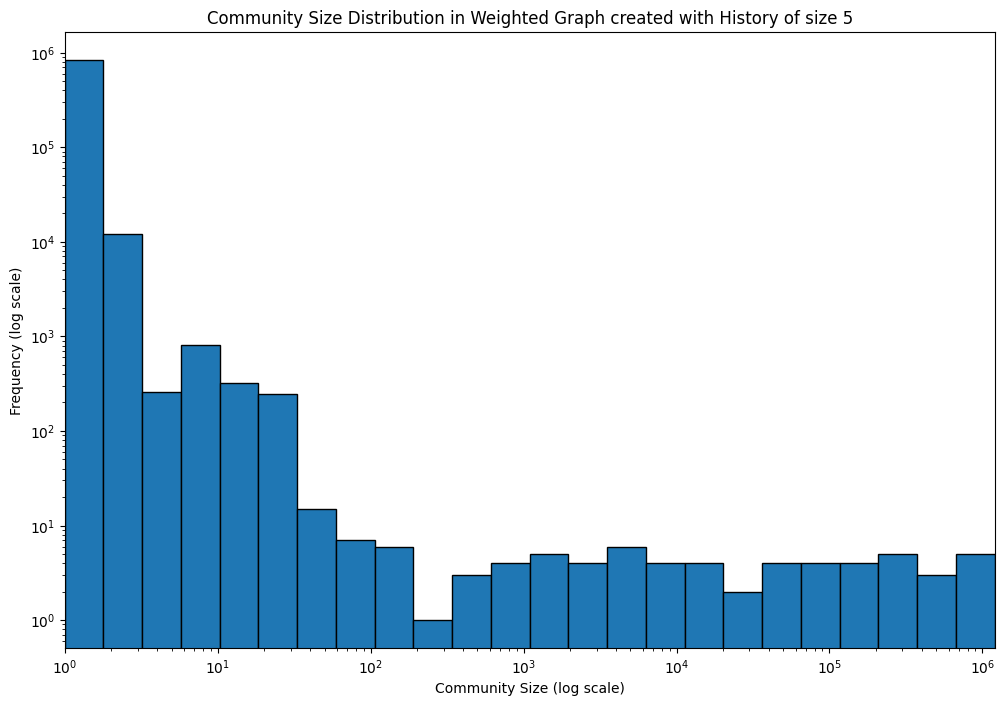

In [28]:
log_bins = np.logspace(np.log10(min(counts)), np.log10(max(counts) + 1), num=25)
plt.figure(figsize=(12,8))

plt.hist(counts,bins= log_bins, log=True, edgecolor='black')

plt.xlim(1, max(counts))

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Community Size (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title(f'Community Size Distribution in {GRAPH_WEIGHT_SUFFIX} Graph created with {GRAPH_SUFFIX} of size {HISTORY}')

plt.savefig(f"clusters{WEIGHT_SUFFIX}_{GRAPH_SUFFIX}_{str(HISTORY)}.png")
plt.show()

In [5]:
def color_hex_to_rgb(color):
    R = int(color[1:3],16)/255
    G = int(color[3:5],16)/255
    B = int(color[5:7],16)/255
    return (R,G,B)

In [6]:
df = pd.read_csv('2022_place_canvas_history_cleared.csv', sep=',')

indices_valid = df['pixel_color']!= '#FFFFFF'
last_valid_index = indices_valid.where(indices_valid).last_valid_index()
df = df.head(last_valid_index+1 )


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155925983 entries, 0 to 155925982
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   pixel_color  object 
 1   user_id_num  int64  
 2   time         float64
 3   X            int64  
 4   Y            int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 5.8+ GB


In [7]:
# 1:30
np_image_count_full = np.zeros([2000, 2000])
for index, row in df.groupby(['X','Y']).agg({"time":"count"}).iterrows():
    np_image_count_full[index]=row["time"]
np_image_count_full[np_image_count_full == 0] = 1
np_image_count_full =np_image_count_full.T

In [26]:
community = 1
community = np.clip(community,0,len(counts))

df_image = df[df["user_id_num"].isin(np.where(membership == indices[community])[0])]
df_image = df_image.groupby(['X','Y']).agg(last_color=('pixel_color', 'last'), count=('time', 'count'))

np_image_color = np.zeros([2000, 2000, 3])
np_image_count = np.zeros([2000, 2000])
for index, row in df_image.iterrows():
    np_image_color[index]=np.array(color_hex_to_rgb(row['last_color']))
    np_image_count[index]=row["count"]
np_image_count/=np_image_count_full
np_image_color = np.transpose(np_image_color, (1, 0, 2))
np_image_count = np_image_count.T

def image_update(c):
    
    plt.figure(figsize=(20,20))
    plt.style.use("dark_background")
    np_image_count_temp=np_image_count>c
    np_image_count_temp=np.clip(np_image_count_temp,0,1)
    np_image = np.concatenate([np_image_color,np_image_count_temp[:, :, np.newaxis]],axis=-1)
    plt.imshow(np_image)
    plt.title(f"Community {community} image filtered with constant {c}")
    
widgets.interact(image_update, c = widgets.FloatSlider(min = 0, max = 1, step = 0.01, value=0, description='Constant'))

interactive(children=(FloatSlider(value=0.0, description='Constant', max=1.0, step=0.01), Output()), _dom_clas…

<function __main__.image_update(c)>

In [38]:
Community_N = 200
N = len(counts[counts>=Community_N])
N

44

In [41]:
# 20 min
folder= "results"
# print(N)
# fig,axs =plt.subplots(N,1,figsize=(20, N*20))
for i in range(N):
    df_image = df[df["user_id_num"].isin(np.where(membership == indices[i])[0])]
    df_image = df_image.groupby(['X','Y']).agg(last_color=('pixel_color', 'last'), count=('time', 'count'))

    np_image_color = np.zeros([2000, 2000, 3])
    np_image_count = np.zeros([2000, 2000])
    for index, row in df_image.iterrows():
        np_image_color[index]=np.array(color_hex_to_rgb(row['last_color']))
        np_image_count[index]=row["count"]
    np_image_count/=np_image_count_full #(np.max(np_image_count)/C)
    np_image_count=np.clip(np_image_count,0,1)
    np_image_color = np.transpose(np_image_color, (1, 0, 2))
    np_image_count = np_image_count.T
    np_image = np.concatenate([np_image_color,np_image_count[:, :, np.newaxis]],axis=-1)

    #axs[i].imshow(np_image_color)
    plt.imsave(f'{folder}/image_{WEIGHT_SUFFIX}{HISTORY}_{i}.png', np_image_color)
    plt.imsave(f'{folder}/count_{WEIGHT_SUFFIX}{HISTORY}_{i}.png', np_image_count, cmap='inferno')
    plt.imsave(f'{folder}/fullimage_{WEIGHT_SUFFIX}{HISTORY}_{i}.png', np.ascontiguousarray(np_image))

In [42]:
# print(N)
# fig,axs =plt.subplots(N,1,figsize=(20, N*20))

df_image = df[df["user_id_num"].isin(np.where(np.isin(membership, indices[counts < Community_N ]))[0])]
df_image = df_image.groupby(['X','Y']).agg(last_color=('pixel_color', 'last'), count=('time', 'count'))

np_image_color = np.zeros([2000, 2000, 3])
np_image_count = np.zeros([2000, 2000])
for index, row in df_image.iterrows():
    np_image_color[index]=np.array(color_hex_to_rgb(row['last_color']))
    np_image_count[index]=row["count"]
np_image_count/=np_image_count_full #(np.max(np_image_count)/C)
np_image_count=np.clip(np_image_count,0,1)
np_image_color = np.transpose(np_image_color, (1, 0, 2))
np_image_count = np_image_count.T
np_image = np.concatenate([np_image_color,np_image_count[:, :, np.newaxis]],axis=-1)

#axs[i].imshow(np_image_color)
plt.imsave(f'{folder}/image_{WEIGHT_SUFFIX}{HISTORY}_rest_{Community_N}.png', np_image_color)
plt.imsave(f'{folder}/count_{WEIGHT_SUFFIX}{HISTORY}_rest_{Community_N}.png', np_image_count, cmap='inferno')
plt.imsave(f'{folder}/fullimage_{WEIGHT_SUFFIX}{HISTORY}_rest_{Community_N}.png', np.ascontiguousarray(np_image))